In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
!pip install torchsummary

In [3]:
# Importing Libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available else "cpu"
#device = "cpu"
print(device)

cuda


In [4]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [5]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

In [13]:
data = GetCIFAR10_TrainData(os.chdir(".."))
trainset = data.download_train_data()
testset = data.download_test_data()

multiples_train = list(range(0, len(trainset), 10))
multiples_test = list(range(0, len(testset), 10))
trainset_1 = torch.utils.data.Subset(trainset, multiples_train)
testset_1 = torch.utils.data.Subset(testset, multiples_test)

trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_1, batch_size=64,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(testset)
print(testset_1)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))
           )


In [14]:
class BasicBlock(nn.Module):
    expansion = 1


    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [15]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [16]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)


        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [17]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified

In [18]:
# Training the model

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 40

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)

EPOCHS : 0


Loss=2.2517895698547363 Batch_id=78 Accuracy=22.68: 100%|██████████| 79/79 [00:05<00:00, 13.67it/s]



Test set: Average loss: 2.1906, Accuracy: 283/1000 (28.30%)

EPOCHS : 1


Loss=1.6042615175247192 Batch_id=78 Accuracy=33.72: 100%|██████████| 79/79 [00:05<00:00, 13.93it/s]



Test set: Average loss: 1.7315, Accuracy: 373/1000 (37.30%)

EPOCHS : 2


Loss=1.2391103506088257 Batch_id=78 Accuracy=37.34: 100%|██████████| 79/79 [00:05<00:00, 15.28it/s]



Test set: Average loss: 1.7480, Accuracy: 402/1000 (40.20%)

EPOCHS : 3


Loss=1.623498558998108 Batch_id=78 Accuracy=41.78: 100%|██████████| 79/79 [00:05<00:00, 13.35it/s]



Test set: Average loss: 1.6722, Accuracy: 436/1000 (43.60%)

EPOCHS : 4


Loss=1.5124132633209229 Batch_id=78 Accuracy=42.00: 100%|██████████| 79/79 [00:05<00:00, 15.00it/s]



Test set: Average loss: 1.4762, Accuracy: 479/1000 (47.90%)

EPOCHS : 5


Loss=1.4877427816390991 Batch_id=78 Accuracy=46.10: 100%|██████████| 79/79 [00:05<00:00, 13.38it/s]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 1.4935, Accuracy: 470/1000 (47.00%)

EPOCHS : 6


Loss=1.5081813335418701 Batch_id=78 Accuracy=54.82: 100%|██████████| 79/79 [00:05<00:00, 15.20it/s]



Test set: Average loss: 1.2678, Accuracy: 549/1000 (54.90%)

EPOCHS : 7


Loss=1.6079118251800537 Batch_id=78 Accuracy=57.20: 100%|██████████| 79/79 [00:07<00:00, 10.90it/s]



Test set: Average loss: 1.2391, Accuracy: 563/1000 (56.30%)

EPOCHS : 8


Loss=1.3319404125213623 Batch_id=78 Accuracy=57.40: 100%|██████████| 79/79 [00:05<00:00, 13.20it/s]

Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 1.2243, Accuracy: 578/1000 (57.80%)

EPOCHS : 9


Loss=0.6029883623123169 Batch_id=78 Accuracy=58.84: 100%|██████████| 79/79 [00:05<00:00, 14.89it/s]



Test set: Average loss: 1.2198, Accuracy: 577/1000 (57.70%)

EPOCHS : 10


Loss=1.7523053884506226 Batch_id=78 Accuracy=57.54: 100%|██████████| 79/79 [00:05<00:00, 13.63it/s]



Test set: Average loss: 1.2185, Accuracy: 576/1000 (57.60%)

EPOCHS : 11


Loss=0.7959964871406555 Batch_id=78 Accuracy=58.28: 100%|██████████| 79/79 [00:05<00:00, 14.33it/s]



Test set: Average loss: 1.2251, Accuracy: 580/1000 (58.00%)

EPOCHS : 12


Loss=1.2353706359863281 Batch_id=78 Accuracy=58.56: 100%|██████████| 79/79 [00:05<00:00, 14.07it/s]

Epoch 00013: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 1.2197, Accuracy: 580/1000 (58.00%)

EPOCHS : 13


Loss=1.4931881427764893 Batch_id=78 Accuracy=58.48: 100%|██████████| 79/79 [00:05<00:00, 14.04it/s]



Test set: Average loss: 1.2242, Accuracy: 585/1000 (58.50%)

EPOCHS : 14


Loss=2.056856870651245 Batch_id=78 Accuracy=58.22: 100%|██████████| 79/79 [00:05<00:00, 14.51it/s]



Test set: Average loss: 1.2182, Accuracy: 581/1000 (58.10%)

EPOCHS : 15


Loss=1.174039363861084 Batch_id=78 Accuracy=59.06: 100%|██████████| 79/79 [00:05<00:00, 14.13it/s]

Epoch 00016: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 1.2199, Accuracy: 582/1000 (58.20%)

EPOCHS : 16


Loss=1.471053957939148 Batch_id=78 Accuracy=58.54: 100%|██████████| 79/79 [00:05<00:00, 15.25it/s]



Test set: Average loss: 1.2144, Accuracy: 583/1000 (58.30%)

EPOCHS : 17


Loss=1.9482734203338623 Batch_id=78 Accuracy=58.76: 100%|██████████| 79/79 [00:05<00:00, 13.47it/s]



Test set: Average loss: 1.2239, Accuracy: 586/1000 (58.60%)

EPOCHS : 18


Loss=1.158054232597351 Batch_id=78 Accuracy=58.02: 100%|██████████| 79/79 [00:05<00:00, 15.06it/s]

Epoch 00019: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 1.2281, Accuracy: 575/1000 (57.50%)

EPOCHS : 19


Loss=0.8833821415901184 Batch_id=78 Accuracy=57.68: 100%|██████████| 79/79 [00:05<00:00, 13.23it/s]



Test set: Average loss: 1.2204, Accuracy: 574/1000 (57.40%)

EPOCHS : 20


Loss=2.069227695465088 Batch_id=78 Accuracy=58.40: 100%|██████████| 79/79 [00:05<00:00, 15.29it/s]



Test set: Average loss: 1.2147, Accuracy: 581/1000 (58.10%)

EPOCHS : 21


Loss=1.098899245262146 Batch_id=78 Accuracy=58.00: 100%|██████████| 79/79 [00:06<00:00, 12.75it/s]



Test set: Average loss: 1.2279, Accuracy: 582/1000 (58.20%)

EPOCHS : 22


Loss=1.1038793325424194 Batch_id=78 Accuracy=59.50: 100%|██████████| 79/79 [00:05<00:00, 15.12it/s]



Test set: Average loss: 1.2139, Accuracy: 581/1000 (58.10%)

EPOCHS : 23


Loss=1.0781748294830322 Batch_id=78 Accuracy=58.78: 100%|██████████| 79/79 [00:06<00:00, 12.98it/s]



Test set: Average loss: 1.2231, Accuracy: 580/1000 (58.00%)

EPOCHS : 24


Loss=1.0306426286697388 Batch_id=78 Accuracy=58.48: 100%|██████████| 79/79 [00:05<00:00, 15.59it/s]



Test set: Average loss: 1.2154, Accuracy: 584/1000 (58.40%)

EPOCHS : 25


Loss=1.551857590675354 Batch_id=78 Accuracy=58.36: 100%|██████████| 79/79 [00:06<00:00, 12.74it/s]



Test set: Average loss: 1.2182, Accuracy: 581/1000 (58.10%)

EPOCHS : 26


Loss=0.4885387122631073 Batch_id=78 Accuracy=58.08: 100%|██████████| 79/79 [00:05<00:00, 15.38it/s]



Test set: Average loss: 1.2291, Accuracy: 579/1000 (57.90%)

EPOCHS : 27


Loss=0.7066235542297363 Batch_id=78 Accuracy=58.44: 100%|██████████| 79/79 [00:06<00:00, 12.76it/s]



Test set: Average loss: 1.2200, Accuracy: 580/1000 (58.00%)

EPOCHS : 28


Loss=1.1567903757095337 Batch_id=78 Accuracy=59.06: 100%|██████████| 79/79 [00:05<00:00, 15.18it/s]



Test set: Average loss: 1.2202, Accuracy: 583/1000 (58.30%)

EPOCHS : 29


Loss=1.6689350605010986 Batch_id=78 Accuracy=59.24: 100%|██████████| 79/79 [00:06<00:00, 12.84it/s]



Test set: Average loss: 1.2168, Accuracy: 584/1000 (58.40%)

EPOCHS : 30


Loss=1.2020138502120972 Batch_id=78 Accuracy=58.14: 100%|██████████| 79/79 [00:05<00:00, 14.87it/s]



Test set: Average loss: 1.2208, Accuracy: 574/1000 (57.40%)

EPOCHS : 31


Loss=1.3134599924087524 Batch_id=78 Accuracy=59.12: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]



Test set: Average loss: 1.2204, Accuracy: 582/1000 (58.20%)

EPOCHS : 32


Loss=1.1162354946136475 Batch_id=78 Accuracy=58.90: 100%|██████████| 79/79 [00:05<00:00, 15.23it/s]



Test set: Average loss: 1.2205, Accuracy: 582/1000 (58.20%)

EPOCHS : 33


Loss=1.1442627906799316 Batch_id=78 Accuracy=59.44: 100%|██████████| 79/79 [00:06<00:00, 12.33it/s]



Test set: Average loss: 1.2188, Accuracy: 581/1000 (58.10%)

EPOCHS : 34


Loss=1.1650511026382446 Batch_id=78 Accuracy=58.74: 100%|██████████| 79/79 [00:05<00:00, 13.87it/s]



Test set: Average loss: 1.2239, Accuracy: 588/1000 (58.80%)

EPOCHS : 35


Loss=0.7998930215835571 Batch_id=78 Accuracy=57.78: 100%|██████████| 79/79 [00:06<00:00, 12.47it/s]



Test set: Average loss: 1.2113, Accuracy: 579/1000 (57.90%)

EPOCHS : 36


Loss=2.132093667984009 Batch_id=78 Accuracy=58.76: 100%|██████████| 79/79 [00:05<00:00, 14.85it/s]



Test set: Average loss: 1.2191, Accuracy: 585/1000 (58.50%)

EPOCHS : 37


Loss=0.9729042649269104 Batch_id=78 Accuracy=58.50: 100%|██████████| 79/79 [00:07<00:00, 10.12it/s]



Test set: Average loss: 1.2143, Accuracy: 579/1000 (57.90%)

EPOCHS : 38


Loss=1.318346381187439 Batch_id=78 Accuracy=58.88: 100%|██████████| 79/79 [00:05<00:00, 15.17it/s]



Test set: Average loss: 1.2222, Accuracy: 579/1000 (57.90%)

EPOCHS : 39


Loss=1.4866119623184204 Batch_id=78 Accuracy=58.28: 100%|██████████| 79/79 [00:06<00:00, 12.68it/s]



Test set: Average loss: 1.2218, Accuracy: 585/1000 (58.50%)



In [19]:
print(type(train_losses[0]))

<class 'torch.Tensor'>


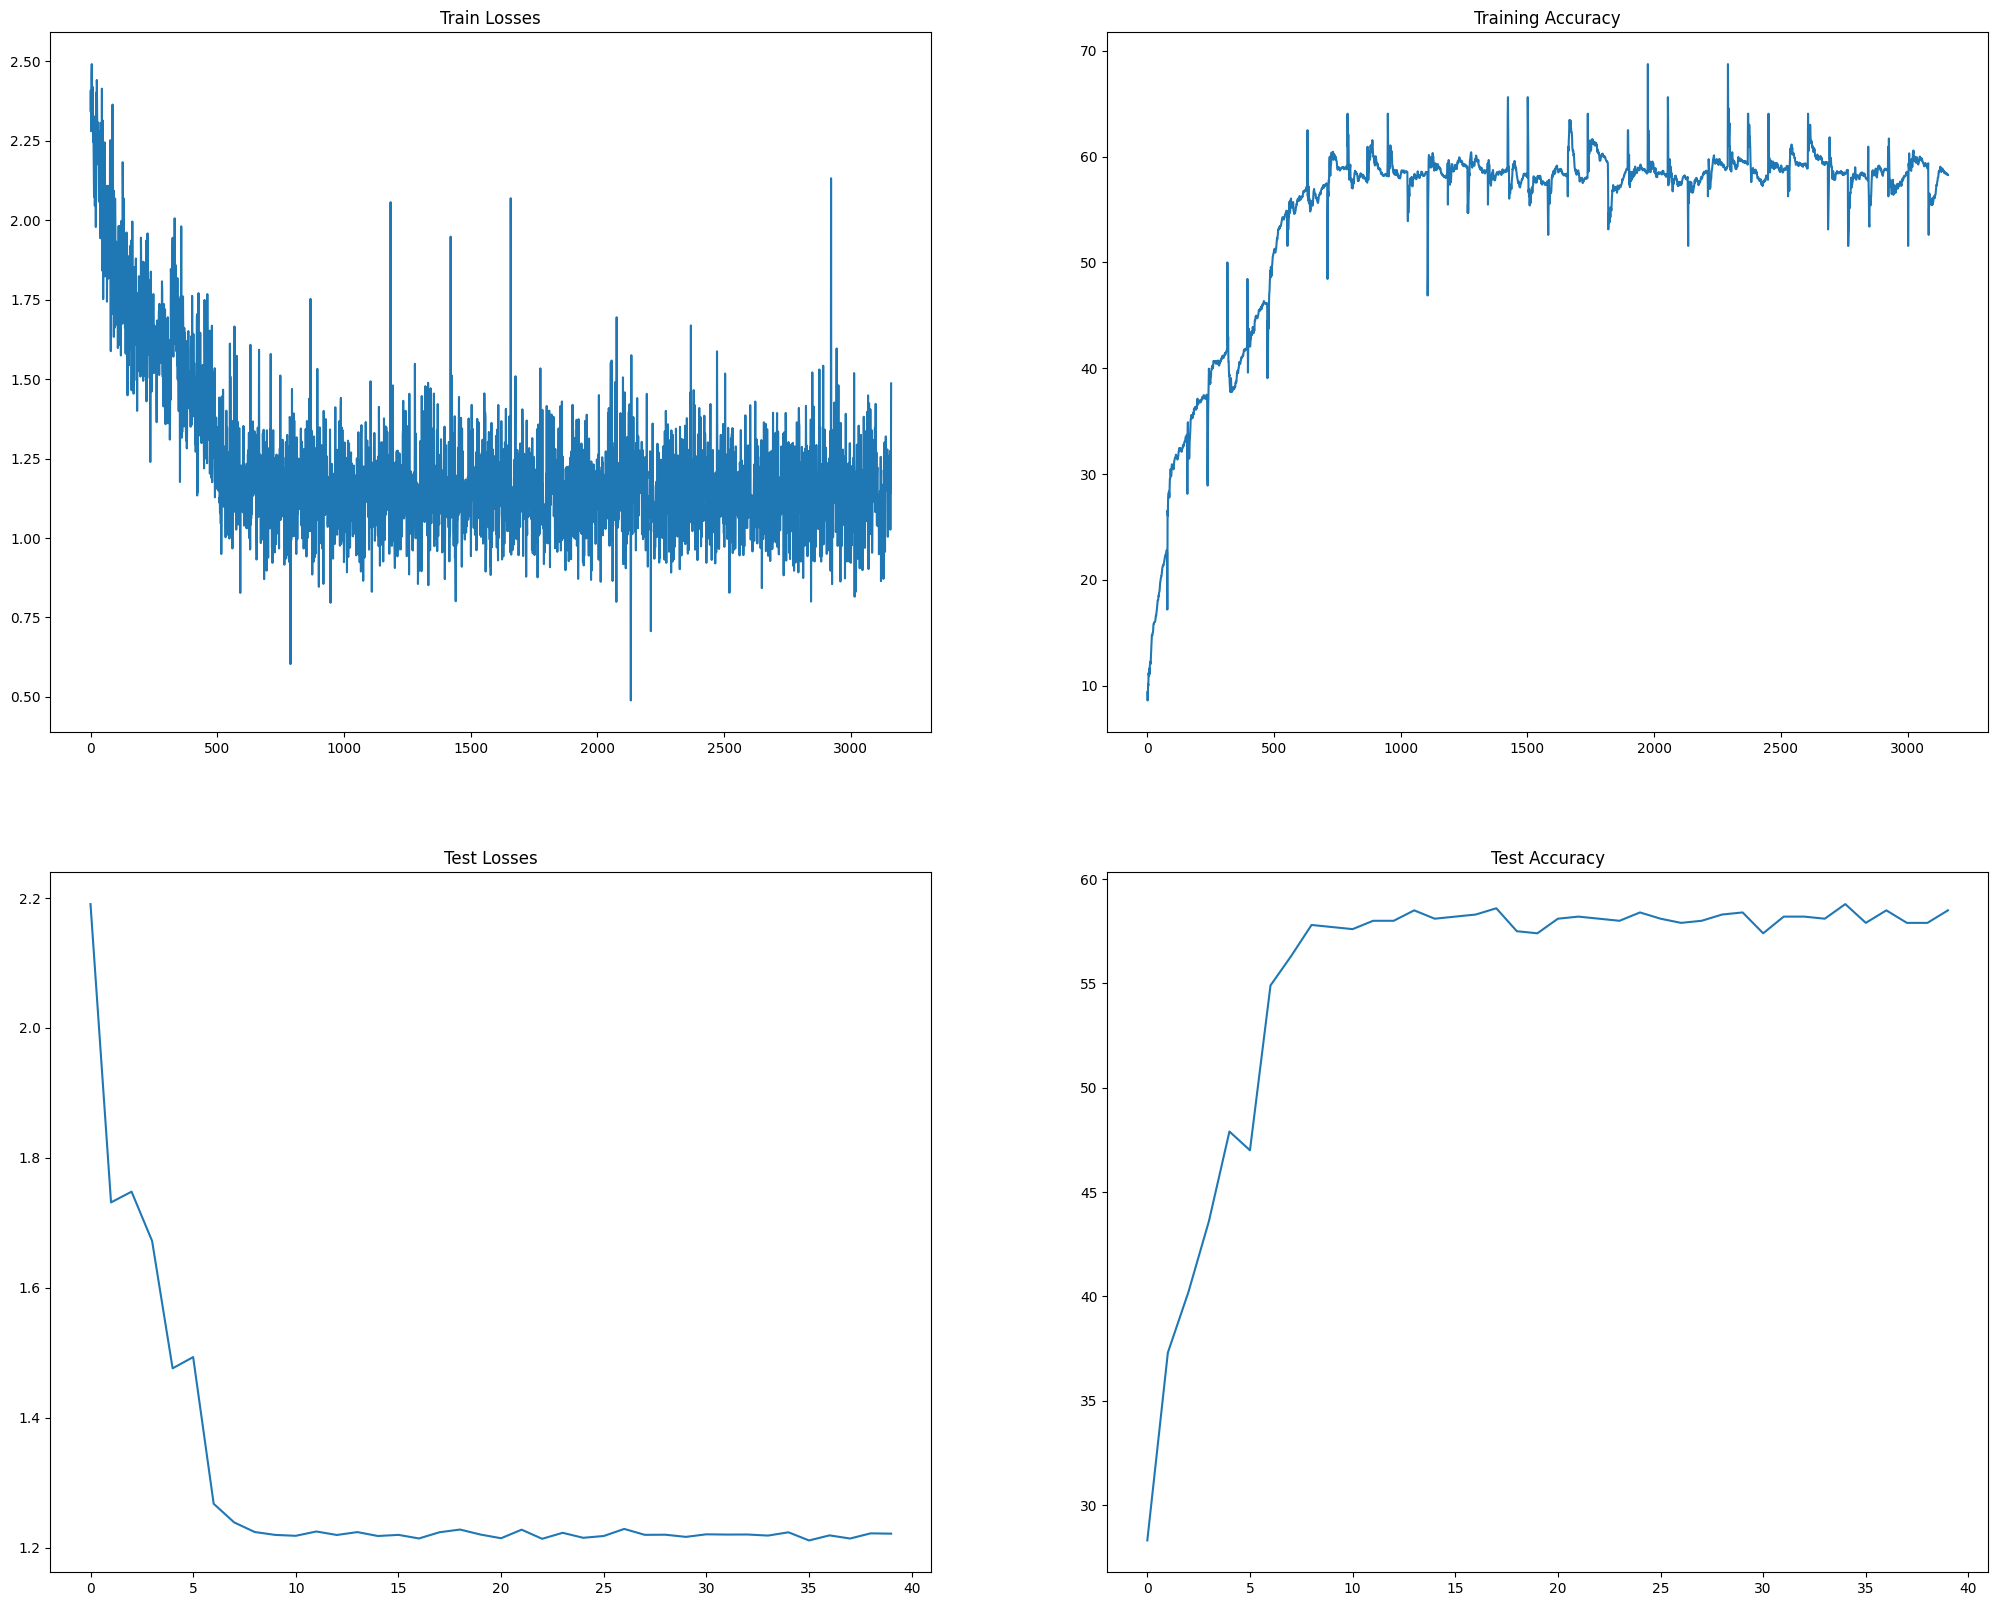

In [20]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

train_losses_new = [loss.item() for loss in train_losses]
axs[0,0].plot(train_losses_new)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

In [ ]:
print(len(train_losses))

160


In [ ]:
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [ ]:

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 17 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [ ]:
# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 17


In [ ]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 3, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])


Visualizing the filters for layer  0


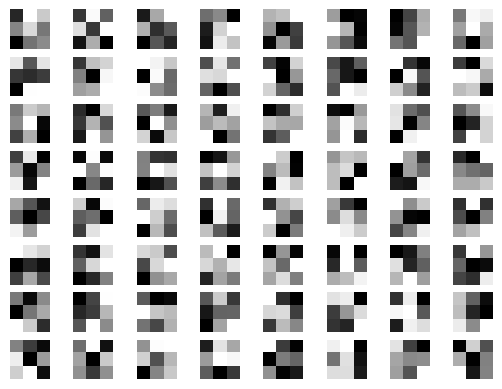

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  1


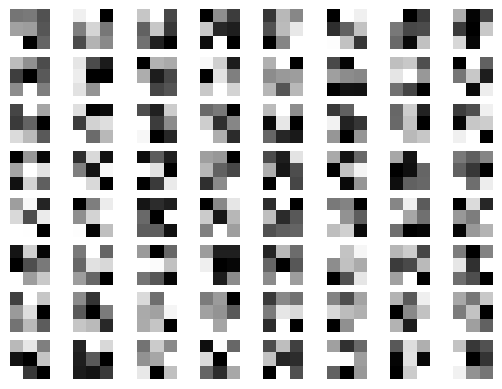

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  2


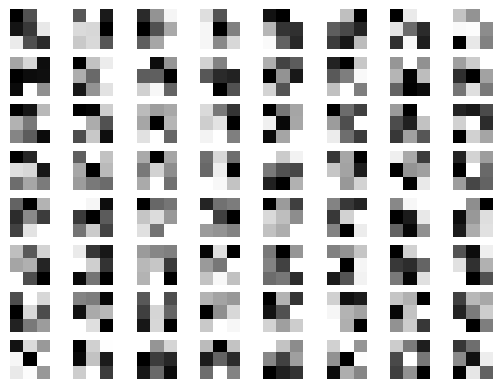

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  3


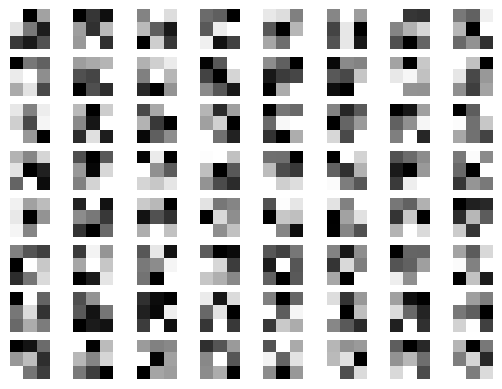

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  4


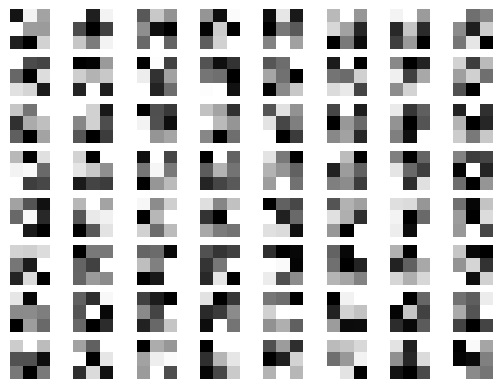

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  5


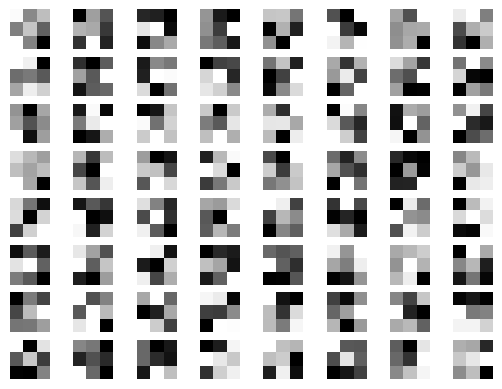

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  6


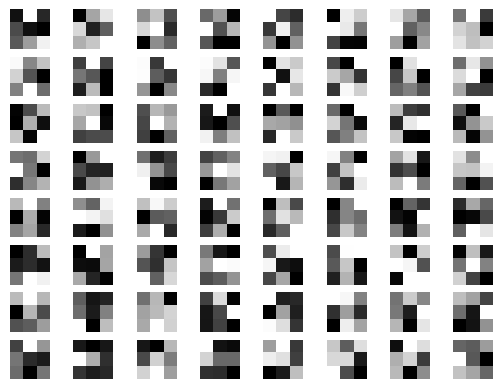

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  7


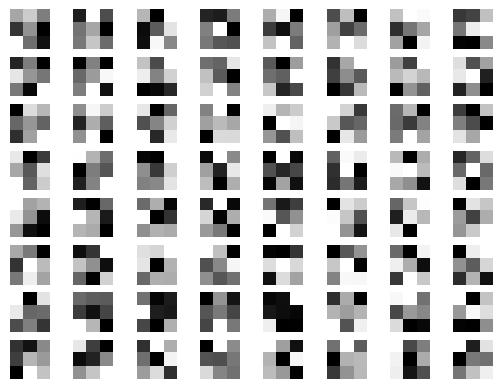

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  8


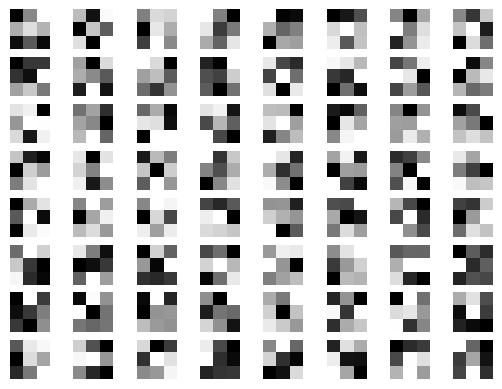

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  9


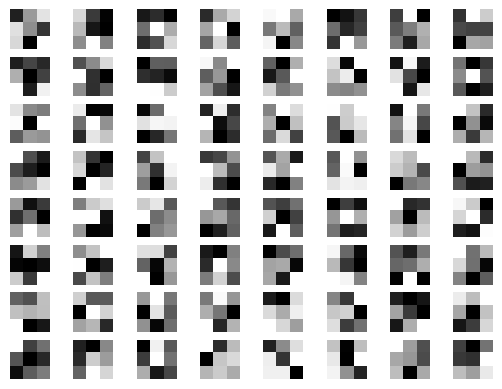

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  10


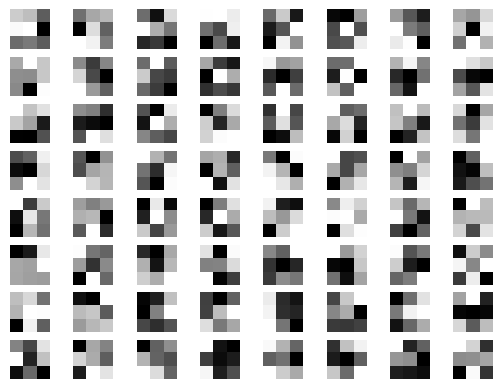

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  11


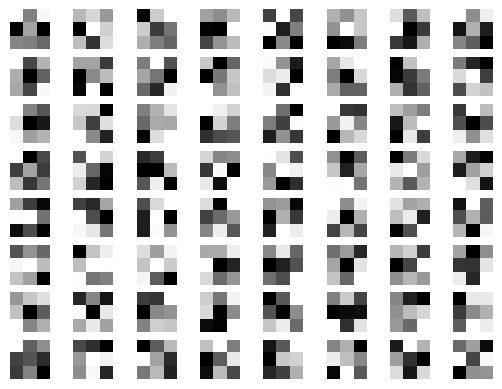

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  12


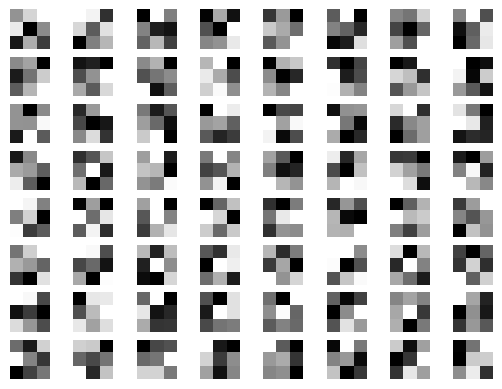

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  13


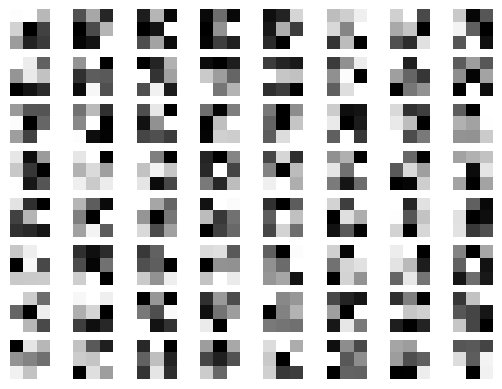

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  14


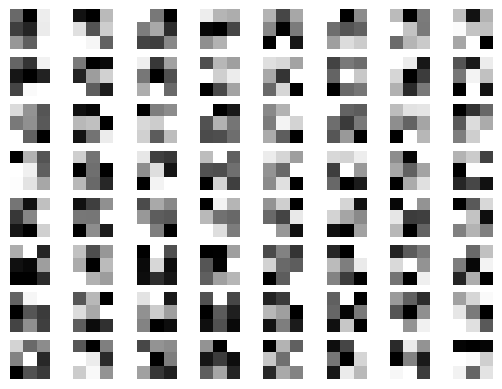

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  15


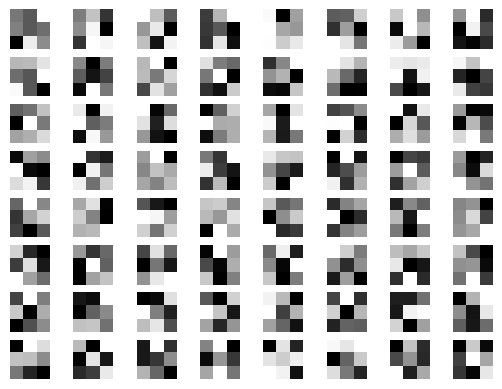

<Figure size 1000x800 with 0 Axes>

Visualizing the filters for layer  16


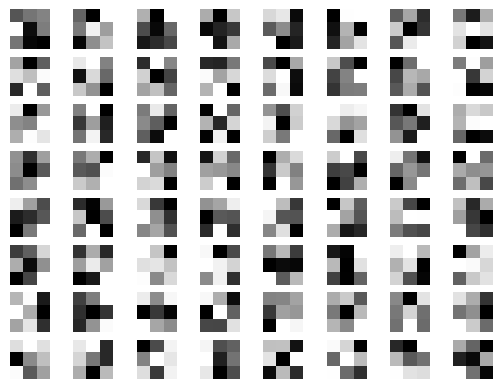

<Figure size 1000x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# visualize the first conv layer filters

for j in range(0,17):

  print("Visualizing the filters for layer ", j)
  for i, filter in enumerate(model_weights[j]):
      if i<64 :
        plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
      else :
         plt.subplot(8, 8, 64)
      plt.imshow(filter[0, :, :].detach(), cmap='gray')
      plt.axis('off')

  plt.figure(figsize=(10, 8))
  plt.show()
  plt.tight_layout()

In [ ]:
for i in range(0,17):
  print("Model weight for Layer ", i, " is ", model_weights[i])

Model weight for Layer  0  is  Parameter containing:
tensor([[[[-1.1199e-01,  1.8973e-01,  1.1605e-01],
          [ 1.9894e-02,  1.3621e-01,  1.4031e-04],
          [-1.6480e-01, -5.5223e-03,  2.7860e-02]],

         [[-4.3494e-02,  3.1154e-02, -1.3602e-01],
          [ 9.3132e-02,  1.4000e-01,  1.8329e-01],
          [ 9.2488e-02,  1.4011e-03, -8.8705e-02]],

         [[-1.6470e-01, -1.5679e-01,  1.1072e-01],
          [-3.0018e-02,  1.4242e-01,  1.4264e-01],
          [ 1.2557e-01, -4.7734e-02, -4.8779e-03]]],


        [[[-1.1459e-01,  1.5221e-01, -5.6695e-02],
          [ 1.1635e-01, -1.1294e-01,  1.6023e-01],
          [-1.6103e-01,  4.7191e-02, -1.8972e-01]],

         [[-4.5018e-03, -7.5226e-02, -1.7141e-01],
          [-3.8791e-02,  1.3869e-01, -1.5355e-01],
          [ 9.9936e-02, -5.3396e-03, -1.3191e-01]],

         [[-2.4316e-02,  8.5129e-02, -6.5863e-02],
          [ 1.1384e-03,  1.2791e-01, -9.7076e-02],
          [-1.6986e-01,  1.5211e-01, -2.6215e-03]]],


        [[[-1